# Exercício MLP

## Raphael Soares Ramos
### Foram realizados testes com a implementação em Numpy e no framework PyTorch no dataset  MNIST e FMNIST. Primeiro, são realizados testes no dataset FMNIST com a MLP implementada em PyTorch. Posteriormente são realizados testes no dataset MNIST com o modelo implementado em Numpy e um teste com a mesma arquitetura avaliada no FMNIST.

#### O modelo avaliado no FMNIST obteve uma acurácia de 87.83%. O melhor modelo em Numpy avaliado no MNIST obteve uma acurácia de 95.04% e o melhor modelo (avaliado neste mesmo conjunto de dados) em PyTorch, 95.73%.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import sys

Usamos transform para gerar novos dados com HorizontalFlip, normalizá-los com média 0.485 e desvio padrão 0.229 e transformar as imagens em tensores. BS é o tamanho do batch!

In [10]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.485,), (0.229,))])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
train_set = datasets.FMNIST('../datasets', download=True, train=True, transform=transform)
test_set = datasets.FMNIST('../datasets', download=True, train=False, transform=transform)


BS = 64
validation_split = 0.2
split = int(np.floor(validation_split * len(train_set)))

train_set, val_set = torch.utils.data.random_split(train_set, [len(train_set)-split, split])

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BS)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BS)

A seguinte célula pegará o próximo elemento do iterator.

In [13]:
inputs, classes = next(iter(train_loader))

In [14]:
print(len(train_set))

48000


No PyTorch, os tensores são da forma (N, C, H, W), onde N é o tamanho do batch, C é a dimensão do tensor, H é a altura e W é a largura.

Pode-se ver que temos imagens monocromáticas com 28 pixels de largura e 28 de altura no dataset. O tamanho do conjunto de treino é 48000, o conjunto de validação terá 12000 imagens e o de teste 10000.

In [15]:
print(inputs.shape, classes.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Na próxima célula são definidas as redes MLP.

#### MLP
Para a rede MLP, primeiro é feito um "flatten" com o método view no tensor de entrada 28x28, que passará a ter tamanho 784. Este novo tensor passará pela então pelas camadas definidas em features. Linear aplica uma transformação Linear (y = xW^T + b). O bias e os pesos serão aprendidos (é possível setar bias para falso). A ReLU, definida por f(x) = max(0,x), é a função de ativação não-linear utilizada para que o modelo seja capaz de aprender transformações não-lineares. Ela é uma das mais utilizadas poe ser quase linear e preservar propriedades interessantes para métodos de descida de gradiente. 

É utilizada um dropout de 30% para evitar overfitting e então, após a última camada Linear, é gerada as probabilidades de cada classe usando LogSoftmax na última camada para calcular o log das probabilidades. 

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(784, 156), 
            nn.ReLU(), 
            nn.Linear(156, 78),
            nn.ReLU(),
            nn.Linear(78, 39),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(39, 10)
        )
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.features(x)
        return self.out(x)

In [17]:
import copy 


def train_loop(model, cost, data, label, optimizer, phase):    
    # zerar os gradientes
    optimizer.zero_grad()
    
    output = model(data)
    # calcular a loss
    loss = cost(output, label) 
    
    # backward pass: computa o gradiente da perda com respeito aos learnable
    # parameters do modelo
    # atualiza parâmetros do otimizador
    if phase == 'train':
        loss.backward()
        optimizer.step()
    return loss, output


def train(model, dataset, optimizer, cost, scheduler, epochs=20):
    best_acc = 0.
    losses, acc = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    for x in range(epochs):
        print('Epoch {}/{}'.format(x + 1, epochs))
        scheduler.step()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss, running_corrects = 0., 0.
            for batch_idx, (data, labels) in enumerate(dataset[phase]):
                data = data.to(device)
                labels = labels.to(device)
                loss, output = train_loop(model, cost, data, labels, optimizer, phase)
                _, preds = torch.max(output, 1)
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / (BS*len(dataset[phase]))
            epoch_acc = running_corrects.double() / (BS*len(dataset[phase]))
            losses.append(epoch_loss)
            acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase.upper(), epoch_loss, epoch_acc))
            if epoch_acc > best_acc and phase == 'val':
                best_acc = copy.deepcopy(epoch_acc)
                best_model_wts = copy.deepcopy(model.state_dict())
        print('-' * 50)
    model.load_state_dict(best_model_wts)
    return model, losses, acc


In [18]:
def test(model, loader, cost):
    model.eval()
    avg_loss, avg_acc, running_corrects = 0., 0., 0.
    y_test, y_pred = [], []
    for batch_idx, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)
        for j in range(output.size()[0]):
            y_test.append(labels.cpu().data[j])
            y_pred.append(preds.cpu().data[j])
        loss = cost(output, labels) 
        running_corrects += torch.sum(preds == labels.data)
        avg_loss += loss.item() * data.size(0)
        avg_acc += running_corrects.double()
    print('Test Loss: {}\nTest Accuracy: {}'.format(avg_loss/(BS*len(loader)), 
                                                    running_corrects.double() / (BS*len(loader))))
    return np.array(y_test), np.array(y_pred)


In [19]:
dataset = {'train': train_loader, 'val': val_loader, 'test': test_loader}

A função de Loss escolhida para treino dos modelos é a NLLLoss devido ao uso do LogSoftmax nos modelos. O otimizador escolhido é o Adam, por ser um método de Learning Rate adaptativa. É utilizado um decaímento exponencial para atualização da learning rate.

Há uma época de treino e uma de validação intercalada para treino de ambos os modelos. A loss na validação ficou um pouco maior do que a loss no treino, o que indica um bom aprendizado do modelo. 

O conjunto de validação é utilizado de forma que os pesos que obterem melhor acurácia no conjunto de validação (também pode-se utilizar os pesos que obterem menor loss no conjunto de validação) serão aqueles utilizados no modelo para o conjunto de teste. 

In [25]:
model = MLP()
model = model.to(device)
cost = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1)
model, loss_mlp, acc_mlp = train(model, dataset, optimizer, cost, scheduler)
y_test_mlp, y_pred_mlp = test(model, dataset['test'], cost)

Epoch 1/20
TRAIN Loss: 0.6744 Acc: 0.7622
VAL Loss: 0.4733 Acc: 0.8202
--------------------------------------------------
Epoch 2/20
TRAIN Loss: 0.4707 Acc: 0.8353
VAL Loss: 0.4064 Acc: 0.8487
--------------------------------------------------
Epoch 3/20
TRAIN Loss: 0.4216 Acc: 0.8524
VAL Loss: 0.3633 Acc: 0.8620
--------------------------------------------------
Epoch 4/20
TRAIN Loss: 0.3912 Acc: 0.8625
VAL Loss: 0.3579 Acc: 0.8640
--------------------------------------------------
Epoch 5/20
TRAIN Loss: 0.3667 Acc: 0.8706
VAL Loss: 0.3402 Acc: 0.8723
--------------------------------------------------
Epoch 6/20
TRAIN Loss: 0.3523 Acc: 0.8755
VAL Loss: 0.3476 Acc: 0.8701
--------------------------------------------------
Epoch 7/20
TRAIN Loss: 0.3352 Acc: 0.8821
VAL Loss: 0.3216 Acc: 0.8826
--------------------------------------------------
Epoch 8/20
TRAIN Loss: 0.3180 Acc: 0.8866
VAL Loss: 0.3131 Acc: 0.8820
--------------------------------------------------
Epoch 9/20
TRAIN Loss: 0

In [26]:
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.metrics import classification_report, confusion_matrix


def plot_confusion_matrix(classes, y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                                    color="white" if cnf_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def plot_loss(loss_mlp):
    epochs = np.arange(1, len(loss_mlp)/2 + 1).astype(np.int)
    loss_train_mlp = np.array([x[1] for x in enumerate(loss_mlp) if x[0]%2==0])
    loss_val_mlp = np.array([x[1] for x in enumerate(loss_mlp) if x[0]%2])
    plt.plot(epochs, loss_train_mlp, label='Train MLP')
    plt.plot(epochs, loss_val_mlp, label='Val MLP')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def plot_acc(acc_mlp):
    epochs = np.arange(1, len(acc_mlp)/2 + 1).astype(np.int)
    acc_train = np.array([x[1] for x in enumerate(acc_mlp) if x[0]%2==0])
    acc_val = np.array([x[1] for x in enumerate(acc_mlp) if x[0]%2])
    plt.plot(epochs, acc_train, label='Train MLP')
    plt.plot(epochs, acc_val, label='Val MLP')    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

Abaixo estão os gráficos e matrizes de confusão para cada um dos modelos. Pelas matrizes de confusão é possível notar que as maior confusão se dá com as classes 6 e 0, o que é esperado visto que são as classes 'camisa' e 'camiseta'.

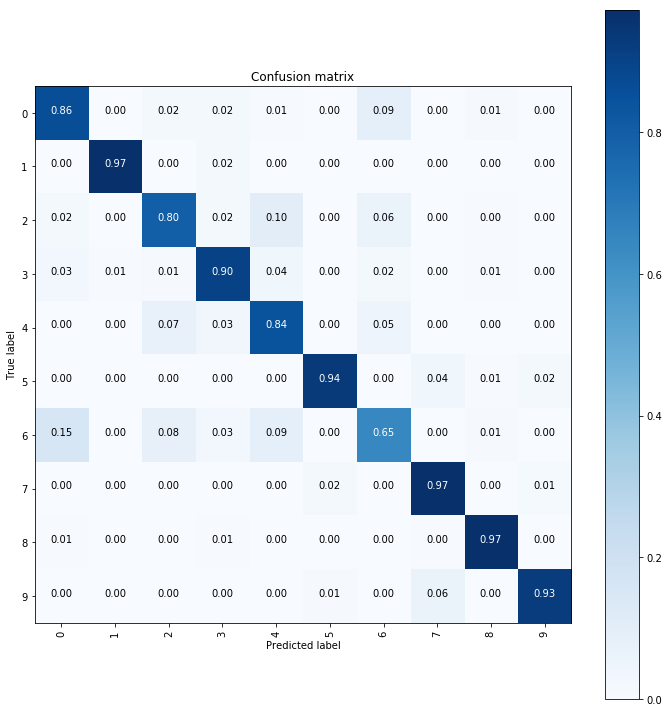

In [27]:
plot_confusion_matrix(np.arange(10), y_test_mlp, y_pred_mlp)

Vamos olhar para uma imagem pertencente a classe 0 e 6.

In [28]:
target_names = list(map(lambda x: str(x), np.arange(10)))
print(classification_report(y_test_mlp, y_pred_mlp, target_names=target_names))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.80      0.80      1000
           3       0.88      0.90      0.89      1000
           4       0.78      0.84      0.81      1000
           5       0.97      0.94      0.95      1000
           6       0.74      0.65      0.69      1000
           7       0.90      0.97      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Os gráficos de desempenho dos modelos nos conjuntos treino e validação são apresentados abaixo.

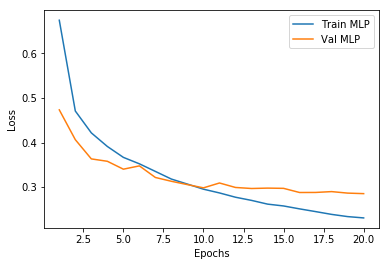

In [29]:
plot_loss(loss_mlp)

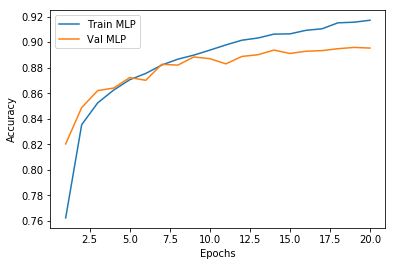

In [30]:
plot_acc(acc_mlp)

## Implementação em Numpy - MNIST

Foi estudada uma implementação em Numpy da MLP. Foram implementadas novas funções e incorporada a possibilidade de uso de learning rates cíclicas [Smith et al. 2017](https://arxiv.org/abs/1506.01186) e o uso da função de ativação ReLU, além de algumas outras mudanças planejadas para deixar o código suscetível a novas implementações sem necessidade de muitas edições. O código completo com referência do código base trabalhado se encontra em [mnist-numpy](https://github.com/MarvelousCoder/mnist-numpy).

A learning rate é um hiperparâmetro que controla o quanto nós ajustamos os parâmetros aprendíveis da nossa rede com respeito ao gradiente. Quanto menor o valor, menor o passo dado ao longo do declive em direção ao mínimo da função de custo. A \textit{learning rate} é um dos hiperparâmetros que devem ser escolhidos com cuidado, pois ela pode ter uma grande influência na convergência do seu modelo.

Leslie propõe ciclos para variar a learning rate. Um ciclo é definido como o número de iterações necessárias para learning rate ir do valor mínimo até o máximo definido no ciclo e voltar ao mínimo. Dadas as constantes $baselr,\, maxlr,\, step \text{ e } \gamma$ que representam, respectivamente, learning rate inicial, learning rate máxima, número de iterações correspondente à metade de um ciclo e constante responsável por diminuir limite superior do ciclo; e as variáveis $itr$ que representa a iteração atual no treinamento e $cycle = \left\lfloor1 + \dfrac{itr}{2 \cdot step}\right\rfloor$ o ciclo atual e a learning rate $lr$ para uma $itr$ qualquer na política exp_range é calculada pela seguinte equação:
$$lr = baselr + (maxlr-baselr)max(0,\, 1-|itr/step - 2cycle + 1|) \gamma^{itr}.$$

Foi implementada e utilizada esta técnica para atualização de learning rate, dado os bons resultados apresentados por Smith. A curto prazo pode não ser benéfica para o aprendizado do modelo, mas a longo prazo há um ganho considerável. Smith apresenta uma maior velocidade de convergência com o uso de learning rates cíclicas (posteriormente esse fênomeno ficou conhecido como "superconvergência")

In [2]:
from src.mnist import Generator as Gen
from src.enums import *

Inicialmente feitos alguns testes com um subconjunto menor dos dados nas seguintes células. É possível notar uma diferença ao usar a função de ativação ReLU no lugar da Sigmoid para poucos dados. Entretanto, para muitos dados 

In [3]:
path = 'data/mnist.pkl.gz'
training_data, validation_data, test_data = Gen.load_data_wrapper(path)

def exec_model(loss, activation, schedule, lr, training_data, validation_data, epochs=30, batch_size=20):
    lr = schedule(0.03, epochs*len(training_data), epochs)
    net = Network([784, 30, 10], lr, cost=loss, activation=activation)
    net.sgd(training_data, epochs, batch_size, lmbda=2.0,
        evaluation_data=validation_data,
        monitor_evaluation_accuracy=True)

In [57]:
loss = Losses.CROSSENTROPY
activation = Activations.RELU
schedule = Schedules.CONSTANT.value
exec_model(loss, activation, schedule, 0.03, training_data[:1000], test_data[:100])

Epoch 1 training complete
Accuracy on evaluation data: 62/100
Epoch 2 training complete
Accuracy on evaluation data: 66/100
Epoch 3 training complete
Accuracy on evaluation data: 78/100
Epoch 4 training complete
Accuracy on evaluation data: 80/100
Epoch 5 training complete
Accuracy on evaluation data: 81/100
Epoch 6 training complete
Accuracy on evaluation data: 84/100
Epoch 7 training complete
Accuracy on evaluation data: 80/100
Epoch 8 training complete
Accuracy on evaluation data: 86/100
Epoch 9 training complete
Accuracy on evaluation data: 86/100
Epoch 10 training complete
Accuracy on evaluation data: 84/100
Epoch 11 training complete
Accuracy on evaluation data: 85/100
Epoch 12 training complete
Accuracy on evaluation data: 86/100
Epoch 13 training complete
Accuracy on evaluation data: 85/100
Epoch 14 training complete
Accuracy on evaluation data: 86/100
Epoch 15 training complete
Accuracy on evaluation data: 86/100
Epoch 16 training complete
Accuracy on evaluation data: 86/100
E

In [58]:
loss = Losses.CROSSENTROPY
activation = Activations.SIGMOID
schedule = Schedules.CONSTANT.value
exec_model(loss, activation, schedule, 0.03, training_data[:1000], test_data[:100])

Epoch 1 training complete
Accuracy on evaluation data: 25/100
Epoch 2 training complete
Accuracy on evaluation data: 40/100
Epoch 3 training complete
Accuracy on evaluation data: 48/100
Epoch 4 training complete
Accuracy on evaluation data: 56/100
Epoch 5 training complete
Accuracy on evaluation data: 65/100
Epoch 6 training complete
Accuracy on evaluation data: 67/100
Epoch 7 training complete
Accuracy on evaluation data: 66/100
Epoch 8 training complete
Accuracy on evaluation data: 68/100
Epoch 9 training complete
Accuracy on evaluation data: 67/100
Epoch 10 training complete
Accuracy on evaluation data: 70/100
Epoch 11 training complete
Accuracy on evaluation data: 68/100
Epoch 12 training complete
Accuracy on evaluation data: 72/100
Epoch 13 training complete
Accuracy on evaluation data: 72/100
Epoch 14 training complete
Accuracy on evaluation data: 72/100
Epoch 15 training complete
Accuracy on evaluation data: 72/100
Epoch 16 training complete
Accuracy on evaluation data: 72/100
E

In [4]:
activation = Activations.RELU
schedule = Schedules.EXP_RANGE.value
exec_model(loss, activation, schedule, 0.03, training_data, test_data)

Epoch 1 training complete
Accuracy on evaluation data: 8997/10000
Epoch 2 training complete
Accuracy on evaluation data: 9060/10000
Epoch 3 training complete
Accuracy on evaluation data: 9122/10000
Epoch 4 training complete
Accuracy on evaluation data: 9136/10000
Epoch 5 training complete
Accuracy on evaluation data: 9180/10000
Epoch 6 training complete
Accuracy on evaluation data: 9189/10000
Epoch 7 training complete
Accuracy on evaluation data: 9179/10000
Epoch 8 training complete
Accuracy on evaluation data: 9196/10000
Epoch 9 training complete
Accuracy on evaluation data: 9210/10000
Epoch 10 training complete
Accuracy on evaluation data: 9192/10000
Epoch 11 training complete
Accuracy on evaluation data: 9204/10000
Epoch 12 training complete
Accuracy on evaluation data: 9211/10000
Epoch 13 training complete
Accuracy on evaluation data: 9207/10000
Epoch 14 training complete
Accuracy on evaluation data: 9200/10000
Epoch 15 training complete
Accuracy on evaluation data: 9223/10000
Epoc

In [6]:
activation = Activations.SIGMOID
schedule = Schedules.EXP_RANGE.value
exec_model(loss, activation, schedule, 0.03, training_data, test_data)

Epoch 1 training complete
Accuracy on evaluation data: 8594/10000
Epoch 2 training complete
Accuracy on evaluation data: 8959/10000
Epoch 3 training complete
Accuracy on evaluation data: 9057/10000
Epoch 4 training complete
Accuracy on evaluation data: 9097/10000
Epoch 5 training complete
Accuracy on evaluation data: 9143/10000
Epoch 6 training complete
Accuracy on evaluation data: 9179/10000
Epoch 7 training complete
Accuracy on evaluation data: 9200/10000
Epoch 8 training complete
Accuracy on evaluation data: 9218/10000
Epoch 9 training complete
Accuracy on evaluation data: 9223/10000
Epoch 10 training complete
Accuracy on evaluation data: 9232/10000
Epoch 11 training complete
Accuracy on evaluation data: 9243/10000
Epoch 12 training complete
Accuracy on evaluation data: 9259/10000
Epoch 13 training complete
Accuracy on evaluation data: 9270/10000
Epoch 14 training complete
Accuracy on evaluation data: 9275/10000
Epoch 15 training complete
Accuracy on evaluation data: 9272/10000
Epoc

In [7]:
activation = Activations.SIGMOID
schedule = Schedules.CONSTANT.value
exec_model(loss, activation, schedule, 0.03, training_data, test_data)

Epoch 1 training complete
Accuracy on evaluation data: 8758/10000
Epoch 2 training complete
Accuracy on evaluation data: 9009/10000
Epoch 3 training complete
Accuracy on evaluation data: 9114/10000
Epoch 4 training complete
Accuracy on evaluation data: 9183/10000
Epoch 5 training complete
Accuracy on evaluation data: 9225/10000
Epoch 6 training complete
Accuracy on evaluation data: 9255/10000
Epoch 7 training complete
Accuracy on evaluation data: 9290/10000
Epoch 8 training complete
Accuracy on evaluation data: 9314/10000
Epoch 9 training complete
Accuracy on evaluation data: 9340/10000
Epoch 10 training complete
Accuracy on evaluation data: 9357/10000
Epoch 11 training complete
Accuracy on evaluation data: 9366/10000
Epoch 12 training complete
Accuracy on evaluation data: 9367/10000
Epoch 13 training complete
Accuracy on evaluation data: 9402/10000
Epoch 14 training complete
Accuracy on evaluation data: 9410/10000
Epoch 15 training complete
Accuracy on evaluation data: 9415/10000
Epoc

In [8]:
activation = Activations.RELU
schedule = Schedules.CONSTANT.value
exec_model(loss, activation, schedule, 0.03, training_data, test_data)

Epoch 1 training complete
Accuracy on evaluation data: 9039/10000
Epoch 2 training complete
Accuracy on evaluation data: 9093/10000
Epoch 3 training complete
Accuracy on evaluation data: 9144/10000
Epoch 4 training complete
Accuracy on evaluation data: 9191/10000
Epoch 5 training complete
Accuracy on evaluation data: 9206/10000
Epoch 6 training complete
Accuracy on evaluation data: 9217/10000
Epoch 7 training complete
Accuracy on evaluation data: 9196/10000
Epoch 8 training complete
Accuracy on evaluation data: 9224/10000
Epoch 9 training complete
Accuracy on evaluation data: 9233/10000
Epoch 10 training complete
Accuracy on evaluation data: 9208/10000
Epoch 11 training complete
Accuracy on evaluation data: 9214/10000
Epoch 12 training complete
Accuracy on evaluation data: 9196/10000
Epoch 13 training complete
Accuracy on evaluation data: 9237/10000
Epoch 14 training complete
Accuracy on evaluation data: 9221/10000
Epoch 15 training complete
Accuracy on evaluation data: 9213/10000
Epoc

#### O modelo em Numpy que obteve maior acurácia foi o que utilizou os seguintes hiperparâmetros: função de ativação sigmoid; learning rate constante = 0.03; 30 épocas; tamanho do batch=20; CrossEntropy como função de custo.

In [20]:
# Dataset MNIST aqui!
model = MLP()
model = model.to(device)
cost = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler =  optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1)
model, loss_mlp, acc_mlp = train(model, dataset, optimizer, cost, scheduler)
y_test_mlp, y_pred_mlp = test(model, dataset['test'], cost)

Epoch 1/20
TRAIN Loss: 0.7377 Acc: 0.7599
VAL Loss: 0.3873 Acc: 0.8696
--------------------------------------------------
Epoch 2/20
TRAIN Loss: 0.4156 Acc: 0.8721
VAL Loss: 0.3288 Acc: 0.8962
--------------------------------------------------
Epoch 3/20
TRAIN Loss: 0.3185 Acc: 0.9052
VAL Loss: 0.2569 Acc: 0.9134
--------------------------------------------------
Epoch 4/20
TRAIN Loss: 0.2671 Acc: 0.9221
VAL Loss: 0.2287 Acc: 0.9246
--------------------------------------------------
Epoch 5/20
TRAIN Loss: 0.2321 Acc: 0.9318
VAL Loss: 0.2076 Acc: 0.9333
--------------------------------------------------
Epoch 6/20
TRAIN Loss: 0.2076 Acc: 0.9392
VAL Loss: 0.1905 Acc: 0.9386
--------------------------------------------------
Epoch 7/20
TRAIN Loss: 0.1889 Acc: 0.9442
VAL Loss: 0.1699 Acc: 0.9442
--------------------------------------------------
Epoch 8/20
TRAIN Loss: 0.1710 Acc: 0.9507
VAL Loss: 0.1680 Acc: 0.9461
--------------------------------------------------
Epoch 9/20
TRAIN Loss: 0